In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


# 0. Importing Libraries

In [2]:
#Main
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Utilities
import random
import re
import pickle
from tqdm.auto import tqdm


#Augmentation
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt')
from nltk.corpus import wordnet


#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_recall_curve


#torch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
import torch.nn as nn
import torch.nn.functional as F

#Hugging Face
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import set_seed
from transformers import get_linear_schedule_with_warmup


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Random States:

In [3]:
# Python and Numpy
seed = 42
random.seed(seed)
np.random.seed(seed)

# Save states (optional, for later restoration)
python_state = random.getstate()
numpy_state = np.random.get_state()

In [4]:
# torch 
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU
torch.backends.cudnn.deterministic = True  # Slower but reproducible
torch.backends.cudnn.benchmark = False

# Save RNG states
torch_rng_state = torch.get_rng_state()
cuda_rng_state = torch.cuda.get_rng_state() if torch.cuda.is_available() else None

In [5]:
#Hugging Face
set_seed(seed)

In [6]:
#Saving all random states

random_states = {
    "python": random.getstate(),
    "numpy": np.random.get_state(),
    "torch_cpu": torch.get_rng_state(),
    "torch_cuda": torch.cuda.get_rng_state() if torch.cuda.is_available() else None,
    "sklearn_seed": seed  # For train_test_split
}

# Save to file
with open("random_states.pkl", "wb") as f:
    pickle.dump(random_states, f)

# 1. Load and Preprocess the Data:

In [7]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [8]:
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

In [9]:
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [10]:
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [11]:
df_train.loc[df_train['toxic'] == 1, ['comment_text']].iloc[0]

comment_text    COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Name: 6, dtype: object

In [12]:
# Define a function to remove punctuation using regular expressions
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Apply the function to the 'text' column
df_train['comment_text'] = df_train['comment_text'].apply(remove_punctuation)

# Define a function to remove special characters using regular expressions
def remove_special_characters(text):
    # Define a regular expression pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'  # This pattern matches any character that is not a letter, digit, or whitespace
    return re.sub(pattern, '', text)

# Apply the function to the 'text' column
df_train['comment_text'] = df_train['comment_text'].apply(remove_special_characters)

### Data Augmentation

In [13]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


label_counts = df_train[label_cols].sum()
max_class_count = label_counts.max()

print("Original class distribution:\n", label_counts)

Original class distribution:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [14]:
def setup_nltk():
    """Handle NLTK data download and path configuration"""
    try:
        nltk_data_dir = '/kaggle/working/nltk_data'
        os.makedirs(nltk_data_dir, exist_ok=True)
        
        if not nltk.data.find('corpora/wordnet'):
            nltk.download('wordnet', download_dir=nltk_data_dir)
            nltk.download('omw-1.4', download_dir=nltk_data_dir)
        
        nltk.data.path.append(nltk_data_dir)
        wordnet.ensure_loaded()
        return True
    except Exception as e:
        print(f"Failed to setup NLTK: {str(e)}")
        return False

def safe_synonym_replacement(text, n=2):
    """Robust synonym replacement with full error handling"""
    if not isinstance(text, str) or not text.strip():
        return text
        
    try:
        words = text.split()
        if len(words) == 0:
            return text
            
        replaceable_words = []
        for word in words:
            try:
                if wordnet.synsets(word):
                    replaceable_words.append(word)
            except:
                continue
                
        if not replaceable_words:
            return text
            
        words_to_replace = random.sample(replaceable_words, min(n, len(replaceable_words)))
        
        for word in words_to_replace:
            try:
                synonyms = []
                for syn in wordnet.synsets(word):
                    for lemma in syn.lemmas():
                        lemma_name = lemma.name().replace('_', ' ')
                        if lemma_name.lower() != word.lower():
                            synonyms.append(lemma_name)
                if synonyms:
                    synonym = random.choice(list(set(synonyms)))
                    text = text.replace(word, synonym, 1)
            except:
                continue
                
        return text
    except Exception as e:
        print(f"Error in synonym replacement: {str(e)}")
        return text

def balance_dataset(df, label_cols):
    """Main augmentation function with complete error handling"""
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
        
    missing_cols = [col for col in ['comment_text'] + label_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    try:
        label_counts = df[label_cols].sum()
        max_count = label_counts.max()
        print("Original distribution:\n", label_counts)
        
        augmented = []
        for label in label_cols:
            needed = max(0, int(0.5 * (max_count - label_counts[label])))
            if needed <= 0:
                continue
                
            samples = df[df[label] == 1]
            if len(samples) == 0:
                continue
                
            print(f"Augmenting {label} (+{needed})")
            
            for _ in range(needed):
                try:
                    sample = samples.sample(1).iloc[0]
                    new_sample = sample.copy()
                    new_sample['comment_text'] = safe_synonym_replacement(sample['comment_text'])
                    augmented.append(new_sample)
                except Exception as e:
                    print(f"Skipping sample due to error: {str(e)}")
                    continue
                    
        if augmented:
            return pd.concat([df, pd.DataFrame(augmented)], ignore_index=True)
        return df.copy()
    except Exception as e:
        print(f"Fatal error in balancing: {str(e)}")
        return df.copy()

# ===== MAIN EXECUTION =====
if not setup_nltk():
    print("Warning: Proceeding without WordNet - augmentation will be limited")

try:
    # Load your data (replace with your actual loading code)
    # df_train = pd.read_csv('your_data.csv')
    
    # Define your target labels
    label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
    # Run augmentation
    df_balanced = balance_dataset(df_train, label_cols)
    
    # Verify results
    print("\nNew distribution:")
    print(df_balanced[label_cols].sum())
    
    # Save if needed
    # df_balanced.to_csv('balanced_data.csv', index=False)
    
except Exception as e:
    print(f"Fatal error in main execution: {str(e)}")
    # Fallback to original data if complete failure
    df_balanced = df_train.copy()


Failed to setup NLTK: 
**********************************************************************
  Resource 'corpora/wordnet' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/root/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
Original distribution:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Augmenting severe_toxic (+6849)
Augmenting obscene (+3422)
Augmenting threat (+7408)
Augmenting insult (+3708)
Augmenting identity_hate (+6944)

New distribution:
toxic            42203
severe_toxic     12986
obscene          31066
threat            9138
insult           30412
identity_hate    12182
dtype: int64


In [15]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_counts = df_train[label_cols].sum()
max_class_count = label_counts.max()

print("Original class distribution:\n", label_counts)

label_counts = df_balanced[label_cols].sum()
max_class_count = label_counts.max()

print("Augmented class distribution:\n", label_counts)

Original class distribution:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Augmented class distribution:
 toxic            42203
severe_toxic     12986
obscene          31066
threat            9138
insult           30412
identity_hate    12182
dtype: int64


In [16]:
df_train['comment_text'].duplicated().sum()

124

In [17]:
def find_duplicates_with_word(df, word, label=None, show_samples=5):
    """
    Find duplicate comments containing specific words, optionally filtered by label
    
    Parameters:
    - df: Your DataFrame
    - word: Word/phrase to search for
    - label: Optional specific label to check (e.g., 'threat')
    - show_samples: Number of examples to display
    """
    # Get all duplicates
    duplicates = df[df['comment_text'].duplicated(keep=False)]
    
    # Filter for word
    mask = duplicates['comment_text'].str.contains(word, case=False, regex=False)
    
    # Optional label filter
    if label:
        mask &= (duplicates[label] == 1)
    
    results = duplicates[mask]
    
    # Display findings
    print(f"\nFound {len(results)} duplicates containing '{word}'", 
          f"(with {label}=1)" if label else "")
    
    if not results.empty:
        display(results[['comment_text'] + label_cols].head(show_samples))
    
    return results

# Example usage:
threat_dupes = find_duplicates_with_word(df_train, "\n\n A barnstar for you \n\n The Original Bar", label='threat')
toxic_dupes = find_duplicates_with_word(df_train, "barnstar", label='toxic')


Found 0 duplicates containing '

 A barnstar for you 

 The Original Bar' (with threat=1)

Found 0 duplicates containing 'barnstar' (with toxic=1)


In [18]:
df_train.drop_duplicates(inplace = True)

In [19]:
print(df_train.shape)
print(df_balanced.shape)

(159571, 8)
(187902, 8)


In [20]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


label_counts = df_train[label_cols].sum()
max_class_count = label_counts.max()

print("Original class distribution:\n", label_counts)

Original class distribution:
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [21]:
comments = df_balanced["comment_text"].tolist()
labels = df_balanced[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values


train_comments, val_comments, train_labels, val_labels = train_test_split(
    comments, labels, test_size=0.2, random_state=seed
)

#emsa7 el [:50] de lma t3ooz trun lkloh

# 2. Tokenization:

In [22]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Changed to BERT

def tokenize(texts):
    return tokenizer(
        texts, 
        padding=True, 
        truncation=True, 
        max_length=128, 
        return_tensors="pt"
    )

# Tokenize data (works exactly the same way)
train_encodings = tokenize(train_comments)
val_encodings = tokenize(val_comments)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# 3. PyTorch Dataset:

In [23]:
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.FloatTensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 4. BERT Model:

### a. Load Pre-trained Roberta Model:

In [31]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
).to("cuda" if torch.cuda.is_available() else "cpu")


#Ems7ha lw 3awz trg3 el adeem
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = ((1 - pt) ** self.gamma * bce_loss).mean()
        return loss

# Set Focal Loss as the model's loss function
model.loss_fct = FocalLoss(gamma=2).to("cuda" if torch.cuda.is_available() else "cpu")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### b. Training Loop

In [32]:
# Hyperparameters
epochs = 1 # Increased to allow early stopping to work
lr = 2e-5
warmup_steps = 100
max_grad_norm = 1.0
patience = 3  # Number of epochs to wait before stopping

# Training Setup
optimizer = AdamW(model.parameters(), lr=lr)

# Learning rate schedule
def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda)

# Tracking
best_metrics = {
    'val_loss': float('inf'),
    'weights': None,
    'epoch': -1
}
history = []
epochs_without_improvement = 0  # Early stopping counter

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(model.device)
        
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss / len(train_loader)

    # --- Validation Phase ---
    avg_val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(model.device)
            
            outputs = model(**inputs, labels=labels)
            avg_val_loss += outputs.loss.item()
    
    avg_val_loss /= len(val_loader)

    # --- Early Stopping Check ---
    if avg_val_loss < best_metrics['val_loss']:
        best_metrics.update({
            'val_loss': avg_val_loss,
            'weights': model.state_dict().copy(),
            'epoch': epoch + 1
        })
        torch.save(best_metrics['weights'], "best_model.pt")
        epochs_without_improvement = 0  # Reset counter
        print(f"↳ New best model saved! (Loss: {avg_val_loss:.4f})")
    else:
        epochs_without_improvement += 1
        print(f"↳ No improvement ({epochs_without_improvement}/{patience})")
        
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}!")
            print(f"Best model was from epoch {best_metrics['epoch']} with val_loss {best_metrics['val_loss']:.4f}")
            break

    # --- Progress Tracking ---
    history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'early_stop_counter': epochs_without_improvement
    })
    
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Final save if no best model was found
if not os.path.exists("best_model.pt"):
    torch.save(model.state_dict(), "final_model.pt")
    print("Saved final model weights (no improvement during training)")

Epoch 1/1 [Train]:   0%|          | 0/9396 [00:00<?, ?it/s]

Validating:   0%|          | 0/2349 [00:00<?, ?it/s]

↳ New best model saved! (Loss: 0.0489)

Epoch 1 Results:
Train Loss: 0.0744 | Val Loss: 0.0489


# 5. Model Evaluation:

### a. Calculating Metrics

In [33]:
model.eval()  # Set model to evaluation mode
val_preds = []
val_true = []

with torch.no_grad():
    for batch in val_loader:  # Use validation DataLoader
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].cpu().numpy()
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        val_preds.extend(probs)
        val_true.extend(labels)

val_preds = np.array(val_preds)
val_true = np.array(val_true)

In [65]:
'''
# Load your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.load_state_dict(torch.load("best_model.pt"))  # or "final_model.pt"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
'''

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Your input sentence
sentence = "GAYS ARE COOL"

# Tokenize and predict
inputs = tokenizer(sentence, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]  # Get probabilities

toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


# results
print(sentence)

print("Predicted probabilities:")
for cls, prob in zip(toxicity_classes, probs):
    print(f"{cls}: {prob:.4f}")

# binary predictions
binary_preds = (probs > 0.5).astype(int)
print("\nBinary predictions (threshold=0.5):")
for cls, pred in zip(toxicity_classes, binary_preds):
    print(f"{cls}: {'✅' if pred else '❌'}")

GAYS ARE COOL
Predicted probabilities:
toxic: 0.7930
severe_toxic: 0.0043
obscene: 0.0029
threat: 0.0027
insult: 0.0261
identity_hate: 0.9405

Binary predictions (threshold=0.5):
toxic: ✅
severe_toxic: ❌
obscene: ❌
threat: ❌
insult: ❌
identity_hate: ✅


In [46]:
# Classification Report (threshold to be controlled)
print(classification_report(
    val_true, 
    val_preds > 0.5,  # Binary predictions
    target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
))

               precision    recall  f1-score   support

        toxic       0.95      0.90      0.93      8439
 severe_toxic       0.84      0.93      0.88      2586
      obscene       0.95      0.94      0.94      6287
       threat       0.96      1.00      0.98      1797
       insult       0.93      0.89      0.91      6088
identity_hate       0.92      0.96      0.94      2456

    micro avg       0.93      0.92      0.93     27653
    macro avg       0.93      0.94      0.93     27653
 weighted avg       0.93      0.92      0.93     27653
  samples avg       0.20      0.20      0.20     27653



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### b. Visualizing:

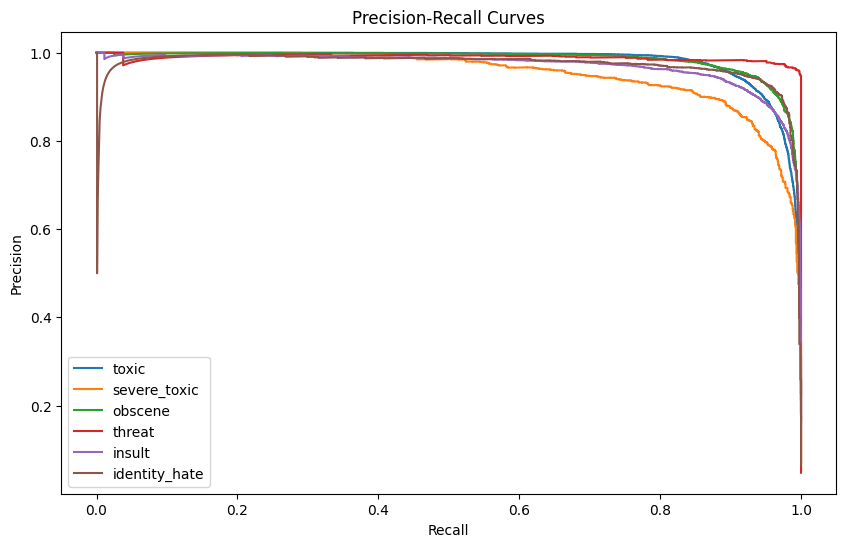

In [55]:
plt.figure(figsize=(10, 6))
for i, label in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
    precision, recall, _ = precision_recall_curve(val_true[:, i], val_preds[:, i])
    plt.plot(recall, precision, label=label)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curves")
plt.show()

### c. Finding Optimal Threshold:

In [56]:
optimal_thresholds = []
for i in range(6):
    precision, recall, thresholds = precision_recall_curve(val_true[:, i], val_preds[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_thresholds.append(thresholds[np.argmax(f1_scores)])
print(f"Optimal Thresholds: {optimal_thresholds}")

Optimal Thresholds: [0.34405026, 0.72372794, 0.4643663, 0.66734, 0.3397155, 0.6887171]


# 6. Making Predictions:

In [57]:
# 1. Tokenize test data
test_encodings = tokenizer(
    df_test["comment_text"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [58]:
# 2. Define Dataset class
class TestDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx]
        }

    def __len__(self):
        return len(self.encodings["input_ids"])

In [59]:
# 3. Create Dataset and Loader
test_dataset = TestDataset(test_encodings)
loader = DataLoader(test_dataset, batch_size=16)

In [60]:
# 4. Run inference
model.eval()
all_probs = []

with torch.no_grad():
    for batch in tqdm(loader, desc="Processing"):
        inputs = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
        all_probs.extend(probs)

        # Memory cleanup
        del inputs, outputs, batch
        torch.cuda.empty_cache()

# 5. Final predictions array
probs = np.vstack(all_probs)

Processing:   0%|          | 0/9573 [00:00<?, ?it/s]

In [61]:
def find_optimal_thresholds(val_true, val_preds, toxicity_classes):
    """
    Calculate optimal thresholds maximizing F1 for each class
    
    Args:
        val_true: Array of true labels (n_samples × n_classes)
        val_preds: Array of predicted probabilities (n_samples × n_classes)
        toxicity_classes: List of class names
        
    Returns:
        Dictionary of {class_name: optimal_threshold}
    """
    optimal_thresholds = {}
    
    for i, class_name in enumerate(toxicity_classes):
        # Get precision-recall curve for this class
        precision, recall, thresholds = precision_recall_curve(
            val_true[:, i], 
            val_preds[:, i]
        )
        
        # Calculating F1 scores
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
        
        # Finding threshold with max F1
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store optimal threshold in dictionary
        optimal_thresholds[class_name] = optimal_threshold
    
    return optimal_thresholds

# Calling the function
toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
optimal_thresholds = find_optimal_thresholds(val_true, val_preds, toxicity_classes)

# Resulting dictionary
print(optimal_thresholds)

{'toxic': 0.34405026, 'severe_toxic': 0.72372794, 'obscene': 0.4643663, 'threat': 0.66734, 'insult': 0.3397155, 'identity_hate': 0.6887171}


In [62]:
# Optimal thresholds (tune these on your validation set)
class_thresholds = optimal_thresholds

# Add probability columns (unchanged)
for i, col in enumerate(toxicity_classes):
    df_test[f"{col}_prob"] = probs[:, i]
    
# Apply custom thresholds for binary predictions
for col in toxicity_classes:
    df_test[f"{col}"] = (df_test[f"{col}_prob"] > class_thresholds[col]).astype(int)

# Check class distribution after thresholding
print("\nPredicted Positive Rates:")
for col in toxicity_classes:
    rate = df_test[f"{col}"].mean()
    print(f"{col}: {rate:.2%} (threshold={class_thresholds[col]})")


Predicted Positive Rates:
toxic: 20.18% (threshold=0.34405025839805603)
severe_toxic: 1.61% (threshold=0.7237279415130615)
obscene: 13.19% (threshold=0.46436628699302673)
threat: 0.41% (threshold=0.6673399806022644)
insult: 9.41% (threshold=0.33971551060676575)
identity_hate: 2.03% (threshold=0.6887171268463135)


In [63]:
df_test

,id,comment_text,toxic_prob,severe_toxic_prob,obscene_prob,threat_prob,insult_prob,identity_hate_prob,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0.998265,0.929604,0.999146,0.003478,0.998447,0.847187,1,1,1,0,1,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0.000720,0.000346,0.000329,0.000189,0.000273,0.000367,0,0,0,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0.000749,0.000332,0.000406,0.000154,0.000286,0.000348,0,0,0,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0.000504,0.000440,0.000339,0.000299,0.000292,0.000504,0,0,0,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0.001435,0.000236,0.000331,0.000126,0.000299,0.000328,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",0.746723,0.003617,0.593360,0.000318,0.022350,0.001081,1,0,1,0,0,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,0.002927,0.000171,0.000895,0.000075,0.000496,0.000267,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",0.001437,0.000391,0.000542,0.000118,0.000433,0.000659,0,0,0,0,0,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",0.003984,0.000596,0.001940,0.000199,0.000833,0.002291,0,0,0,0,0,0


In [ ]:
#for 0.5 threshold
'''
for col in toxicity_classes:
    df_test.drop([f"{col}_prob"], inplace = True, axis = 1)
    df_test.drop([f"{col}_pred"], inplace = True, axis = 1)

# Add probability columns (unchanged)
for i, col in enumerate(toxicity_classes):
    df_test[f"{col}_prob"] = probs[:, i]
    
# Apply custom thresholds for binary predictions
for col in toxicity_classes:
    #df_test[f"{col}_pred"] = (df_test[f"{col}_prob"] > class_thresholds[col]).astype(int)   #When usibng train test split
    df_test[f"{col}"] = (df_test[f"{col}_prob"] > 0.5).astype(int)

# Check class distribution after thresholding
print("\nPredicted Positive Rates:")
for col in toxicity_classes:
    rate = df_test[f"{col}"].mean()
    print(f"{col}: {rate:.2%} (threshold={0.5})")

'''

In [64]:
probs[:, i]

array([8.4718698e-01, 3.6740839e-04, 3.4793140e-04, ..., 6.5938110e-04,
       2.2910391e-03, 1.2352773e-03], dtype=float32)

In [66]:
submission = df_test.drop(['comment_text'], axis = 1)
for col in toxicity_classes:
    submission.drop([f"{col}_prob"], inplace = True, axis = 1)

submission.to_csv('submission.csv', index=False)

In [67]:
model.save_pretrained('bert_model_weights')

In [68]:
submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1,1,1,0,1,1
1,0000247867823ef7,0,0,0,0,0,0
2,00013b17ad220c46,0,0,0,0,0,0
3,00017563c3f7919a,0,0,0,0,0,0
4,00017695ad8997eb,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,1,0,1,0,0,0
153160,fffd7a9a6eb32c16,0,0,0,0,0,0
153161,fffda9e8d6fafa9e,0,0,0,0,0,0
153162,fffe8f1340a79fc2,0,0,0,0,0,0


# 99. Try

In [ ]:
df_balanced.to_csv('augmented.csv')

#### Single Sentence Prediction:

In [ ]:
'''
# Load your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
model.load_state_dict(torch.load("best_model.pt"))  # or "final_model.pt"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
'''

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set to evaluation mode

# Your input sentence
sentence = "SLUT"

# Tokenize and predict
inputs = tokenizer(sentence, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]  # Get probabilities

toxicity_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]


# results
print(sentence)

print("Predicted probabilities:")
for cls, prob in zip(toxicity_classes, probs):
    print(f"{cls}: {prob:.4f}")

# binary predictions
binary_preds = (probs > 0.5).astype(int)
print("\nBinary predictions (threshold=0.5):")
for cls, pred in zip(toxicity_classes, binary_preds):
    print(f"{cls}: {'✅' if pred else '❌'}")

#### Multi-Sentence Prediction:

In [ ]:
sentences = [
    "You're stupid!",
    "Thanks for your help",
    "Go back to your country"
]

# Tokenize batch
inputs = tokenizer(sentences, 
                 padding=True, 
                 truncation=True, 
                 max_length=128, 
                 return_tensors="pt").to(device)

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    all_probs = torch.sigmoid(outputs.logits).cpu().numpy()

# Display results
for i, sentence in enumerate(sentences):
    print(f"\nSentence: '{sentence}'")
    for cls, prob in zip(toxicity_classes, all_probs[i]):
        print(f"{cls}: {prob:.4f}")

## For Threat Problem:

### a. Focal Loss

In [ ]:
'''
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
).to("cuda" if torch.cuda.is_available() else "cpu")


#Ems7ha lw 3awz trg3 el adeem
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        loss = ((1 - pt) ** self.gamma * bce_loss).mean()
        return loss

# Set Focal Loss as the model's loss function
model.loss_fct = FocalLoss(gamma=2).to("cuda" if torch.cuda.is_available() else "cpu")

'''

### b. Class Weights

In [ ]:
'''
# Calculate class weights (inverse of class frequencies)
class_counts = np.array([sum(train_labels[:, i]) for i in range(6)])  # Count per class
class_weights = torch.tensor(
    (1.0 / (class_counts + 1e-6)) * (len(train_labels)/6),  # Normalize
    dtype=torch.float32,
    device=device
)

# Modify your model initialization
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
)
model.loss_fct = nn.BCEWithLogitsLoss(pos_weight=class_weights)
'''

### c. Data Loader

In [ ]:
'''
from torch.utils.data import WeightedRandomSampler

# Calculate sample weights (higher for threat-containing samples)
sample_weights = torch.where(
    train_labels[:, 3] == 1,  # Threat is index 3
    torch.tensor(50.0),       # 50x higher sampling for threats
    torch.tensor(1.0)
)

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Modify your DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,  # Replaces shuffle=True
    num_workers=4
)
'''